In [12]:
# Pitch‐based comparative analysis using process_pitch
import os
import glob
import pandas as pd
import numpy as np
from librosa.sequence import dtw

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Config
LOCAL_BASE = "./data-analysis/downloaded_audios"
REFS = {
    "none":   "./data-analysis/reference_audios/mary.wav",
    "before": "./data-analysis/reference_audios/twinkle.wav",
    "after":  "./data-analysis/reference_audios/twinkle.wav",
}
DYN_REFS = {
    "none":   "./data-analysis/reference_audios/mary_dynamics.wav",
    "before": "./data-analysis/reference_audios/twinkle_dynamics.wav",
    "after":  "./data-analysis/reference_audios/twinkle_dynamics.wav",
}
TEMPO_REFS = {
    "none":   "./data-analysis/reference_audios/mary_tempo.wav",
    "before": "./data-analysis/reference_audios/twinkle_tempo.wav",
    "after":  "./data-analysis/reference_audios/twinkle_tempo.wav",
}

GPUs: []


In [13]:
import librosa
from essentia.standard import MonoLoader
from feature_extraction.pitch import CrepePitchExtractor
from feature_extraction.pitch_utils import compute_dynamic_params_crepe, filter_pitch_by_rms
from feature_extraction.tempo import calculate_dynamic_tempo_beattracker
from utils.extraction_utils import filter_low_confidence
from utils.smoothing import smooth_data
from config import N_FFT, HOP_LENGTH

def load_audio(file_path, sample_rate):
    """Loads, trims, enhances, and resamples audio from a file path."""
    try:
        # Load audio using MonoLoader
        audio = MonoLoader(filename=file_path, sampleRate=sample_rate)()
        # Trim leading and trailing silence
        audio, _ = librosa.effects.trim(audio, top_db=20)
        # Enhance audio quality
        enhanced_audio = librosa.util.normalize(audio)
        return audio, None
    except Exception as e:
        return None, str(e)

def calculate_dynamics(audio, sr):
    """Calculates RMS energy."""
    return librosa.feature.rms(y=audio, frame_length=N_FFT, hop_length=HOP_LENGTH)[0]

def extract_pitch(file_path, sample_rate=16000, method="crepe"):
    """Extracts pitch from audio bytes without caching or highlighting."""
    # 1. Calculate dynamics (RMS) at 44.1kHz for filtering
    audio_44k, error = load_audio(file_path, sample_rate=44100)
    if error:
        return None, f"Error loading audio for dynamics: {error}"
    rms = calculate_dynamics(audio_44k, 44100)

    # 2. Load audio at 16kHz for pitch extraction
    audio_16k, error = load_audio(file_path, sample_rate=sample_rate)
    if error:
        return None, f"Error loading audio for pitch: {error}"

    # 3. Compute dynamic CREPE parameters
    dur_sec = len(audio_16k) / sample_rate
    hop_ms, _, batch = compute_dynamic_params_crepe(dur_sec)

    # 4. Extract pitch
    if method == "crepe":
        extractor = CrepePitchExtractor()
        _, pitch, conf = extractor.extract_pitch(audio_16k, hop_ms=hop_ms, batch=batch)
    else:
        return None, f"Method {method} not implemented for this context."

    # 5. Filter low-confidence and low-energy frames
    thresh = 0.1 * np.max(conf)
    pitch = filter_low_confidence(pitch, conf, thresh=thresh)
    if pitch is None:
        return None, "No high-confidence pitch found"
    pitch = filter_pitch_by_rms(pitch, rms)

    # 6. Smooth pitch
    smoothed_pitch = smooth_data(pitch, filter_type='median', window_size=5)
    smoothed_pitch[smoothed_pitch == 0] = np.nan

    return smoothed_pitch, None

def extract_dynamics(file_path, sample_rate=44100):
    """Loads an audio file and returns its RMS dynamics curve."""
    audio, error = load_audio(file_path, sample_rate=sample_rate)
    if error:
        return None, f"Error loading audio for dynamics: {error}"
    # The calculate_dynamics function already returns the RMS curve
    rms_curve = calculate_dynamics(audio, sample_rate)
    return rms_curve, None

def extract_tempo(file_path, sample_rate=44100):
    """Loads audio and extracts the dynamic tempo curve."""
    audio, error = load_audio(file_path, sample_rate=sample_rate)
    if error:
        return None, f"Error loading audio for tempo: {error}"
    
    duration = len(audio) / sample_rate
    tempo_curve, confidence, _ = calculate_dynamic_tempo_beattracker(audio, sample_rate, duration)
    
    # The function already returns NaNs for low confidence, which is what we want.
    return tempo_curve, None

def interpolate_pitch(pitch_array, target_len):
    """Interpolates a pitch array to a target length, handling NaNs."""
    # Create an array of indices for the original pitch data
    original_indices = np.arange(len(pitch_array))
    # Create an array of indices for the target length
    target_indices = np.linspace(0, len(pitch_array) - 1, target_len)
    
    # Find where the original pitch data is valid (not NaN)
    valid_mask = ~np.isnan(pitch_array)
    
    # If there are no valid pitch points, return an array of NaNs
    if not np.any(valid_mask):
        return np.full(target_len, np.nan)
        
    # Perform interpolation only on the valid data points
    interpolated_pitch = np.interp(
        target_indices, 
        original_indices[valid_mask], 
        pitch_array[valid_mask]
    )
    return interpolated_pitch

In [14]:
# --- Pre-calculate ALL reference curves ---
print("Pre-calculating reference pitch curves...")
ref_pitch_curves = {}
processed_refs = {} 
for condition, ref_path in REFS.items():
    if ref_path not in processed_refs:
        pitch, error = extract_pitch(ref_path)
        if error: raise Exception(f"FATAL: Could not process reference audio {ref_path}: {error}")
        processed_refs[ref_path] = pitch
    ref_pitch_curves[condition] = processed_refs[ref_path]

print("Pre-calculating reference dynamics curves...")
ref_dyn_curves = {}
processed_dyn_refs = {}
for condition, ref_path in DYN_REFS.items():
    if ref_path not in processed_dyn_refs:
        dynamics, error = extract_dynamics(ref_path)
        if error: raise Exception(f"FATAL: Could not process reference audio {ref_path}: {error}")
        processed_dyn_refs[ref_path] = dynamics
    ref_dyn_curves[condition] = processed_dyn_refs[ref_path]
    
print("Pre-calculating reference tempo curves...")
ref_tempo_curves = {}
processed_tempo_refs = {}
for condition, ref_path in TEMPO_REFS.items():
    if ref_path not in processed_tempo_refs:
        tempo, error = extract_tempo(ref_path)
        if error: raise Exception(f"FATAL: Could not process reference audio {ref_path}: {error}")
        processed_tempo_refs[ref_path] = tempo
    ref_tempo_curves[condition] = processed_tempo_refs[ref_path]
print("...done.")

Pre-calculating reference pitch curves...


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame


Pre-calculating reference dynamics curves...
Pre-calculating reference tempo curves...
...done.


In [15]:
records = []
pitch_curves = []
dynamics_curves = [] 
tempo_curves = []

# Loop through each subject and condition to process paired files
for subj in os.listdir(LOCAL_BASE):
    base = os.path.join(LOCAL_BASE, subj)
    if not os.path.isdir(base):
        continue
    
    for cond in ['none', 'before', 'after']:
        # Find the corresponding pitch and dynamics files for the subject and condition
        pitch_path_list = glob.glob(f"{base}/**/*{cond}*pitch*.wav", recursive=True)
        dyn_path_list = glob.glob(f"{base}/**/*{cond}*dynamics*.wav", recursive=True)
        tempo_path_list = glob.glob(f"{base}/**/*{cond}*tempo*.wav", recursive=True)

        # Ensure both a pitch and dynamics file were found before proceeding
        if not all([pitch_path_list, dyn_path_list, tempo_path_list]):
            print(f"Warning: Missing a pitch, dynamics, or tempo file for {subj}/{cond}. Skipping.")
            continue
        
        pitch_path = pitch_path_list[0]
        dyn_path = dyn_path_list[0]
        tempo_path = tempo_path_list[0]

        # --- 1. Pitch Analysis (Existing Logic) ---
        ref_pitch = ref_pitch_curves[cond]
        subj_pitch, error = extract_pitch(pitch_path)
        if error:
            print(f"Error on pitch file {pitch_path}: {error}")
            continue
        
        pitch_curves.append({
            "subjectId": subj, "condition": cond,
            "subj_pitch": subj_pitch, "ref_pitch": ref_pitch
        })
        
        subj_pitch_clean = subj_pitch[~np.isnan(subj_pitch)]
        ref_pitch_clean = ref_pitch[~np.isnan(ref_pitch)]

        if len(subj_pitch_clean) == 0 or len(ref_pitch_clean) == 0:
            print(f"Warning: Skipping DTW for pitch on {pitch_path} due to empty pitch array.")
            continue

        _, wp_pitch = dtw(np.log1p(subj_pitch_clean), np.log1p(ref_pitch_clean), backtrack=True)
        i1_p, i0_p = zip(*wp_pitch)
        diff_pitch = subj_pitch_clean[np.array(i1_p)] - ref_pitch_clean[np.array(i0_p)]
        rmse_pitch = np.sqrt((diff_pitch**2).mean())
        semitone_in_hz = 2**(1/12) - 1
        tolerance = (semitone_in_hz / 2) * ref_pitch_clean[np.array(i0_p)]
        correct_notes_ratio = np.mean(np.abs(diff_pitch) < tolerance)

        # --- 2. Dynamics Analysis (New Logic) ---
        ref_dyn = ref_dyn_curves[cond]
        subj_dyn, error = extract_dynamics(dyn_path)
        if error:
            print(f"Error on dynamics file {dyn_path}: {error}")
            continue
            
        dynamics_curves.append({
            "subjectId": subj, "condition": cond,
            "subj_dyn": subj_dyn, "ref_dyn": ref_dyn
        })

        _, wp_dyn = dtw(subj_dyn, ref_dyn, backtrack=True)
        i1_d, i0_d = zip(*wp_dyn)
        diff_dyn = subj_dyn[np.array(i1_d)] - ref_dyn[np.array(i0_d)]
        rmse_dynamics = np.sqrt((diff_dyn**2).mean())

        ref_tempo = ref_tempo_curves[cond]
        subj_tempo, error = extract_tempo(tempo_path)
        if error:
            print(f"Error on tempo file {tempo_path}: {error}")
            continue

        tempo_curves.append({
            "subjectId": subj, "condition": cond,
            "subj_tempo": subj_tempo, "ref_tempo": ref_tempo
        })

        subj_tempo_clean = subj_tempo[~np.isnan(subj_tempo)]
        ref_tempo_clean = ref_tempo[~np.isnan(ref_tempo)]

        if len(subj_tempo_clean) == 0 or len(ref_tempo_clean) == 0:
            print(f"Warning: Skipping DTW for tempo on {tempo_path} due to empty tempo array.")
            rmse_tempo, diff_tempo = np.nan, np.array([np.nan]) # Assign NaN if no data
        else:
            _, wp_tempo = dtw(subj_tempo_clean, ref_tempo_clean, backtrack=True)
            i1_t, i0_t = zip(*wp_tempo)
            diff_tempo = subj_tempo_clean[np.array(i1_t)] - ref_tempo_clean[np.array(i0_t)]
            rmse_tempo = np.sqrt((diff_tempo**2).mean())

        # --- 3. Append Combined Record ---
        records.append({
            "subjectId": subj,
            "condition": cond,
            # Pitch Metrics
            "rmse": rmse_pitch,
            "mean_subj_pitch": np.mean(subj_pitch_clean),
            "std_subj_pitch": np.std(subj_pitch_clean),
            "pitch_bias_hz": np.mean(diff_pitch),
            "pitch_inaccuracy_std": np.std(diff_pitch),
            "percent_notes_correct": correct_notes_ratio * 100,
            # Dynamics Metrics
            "dynamics_rmse": rmse_dynamics,
            "dynamics_bias": np.mean(diff_dyn), # Tendency to be louder (positive) or softer (negative)
            "dynamics_inaccuracy_std": np.std(diff_dyn), # Consistency of dynamics matching
            # Tempo Metrics
            "tempo_rmse": rmse_tempo,
            "tempo_bias": np.mean(diff_tempo), # Tendency to be faster (positive) or slower (negative)
            "tempo_inaccuracy_std": np.std(diff_tempo) # Consistency of tempo matching
        })

df_metrics = pd.DataFrame(records)
df_metrics.head()

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`


[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `./models/crepe-small-1.pb`
[   INFO   ] FrameCutter: dropping incomplete frame


,subjectId,condition,rmse,mean_subj_pitch,std_subj_pitch,pitch_bias_hz,pitch_inaccuracy_std,percent_notes_correct,dynamics_rmse,dynamics_bias,dynamics_inaccuracy_std,tempo_rmse,tempo_bias,tempo_inaccuracy_std
0,e3c1bd68,none,115.030693,160.215225,21.841621,-110.382263,32.370003,0.000000,0.127347,0.059737,0.112467,14.281746,-10.690246,9.470317
1,e3c1bd68,before,146.505280,163.278061,34.338501,-124.778854,76.772614,0.000000,0.062792,0.037323,0.050497,57.161486,-52.582055,22.417917
2,e3c1bd68,after,139.228592,171.381699,32.537601,-115.684669,77.470375,0.000000,0.051840,0.027154,0.044159,NaN,NaN,NaN
3,eamv7woj,none,116.200745,159.892258,23.263056,-112.638496,28.551363,0.000000,0.047584,0.019953,0.043198,NaN,NaN,NaN
4,eamv7woj,before,87.809402,175.952667,39.348423,-77.013992,42.182186,9.067017,0.043686,0.021902,0.037800,12.555564,0.328170,12.551274


/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1474149887.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1474149887.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


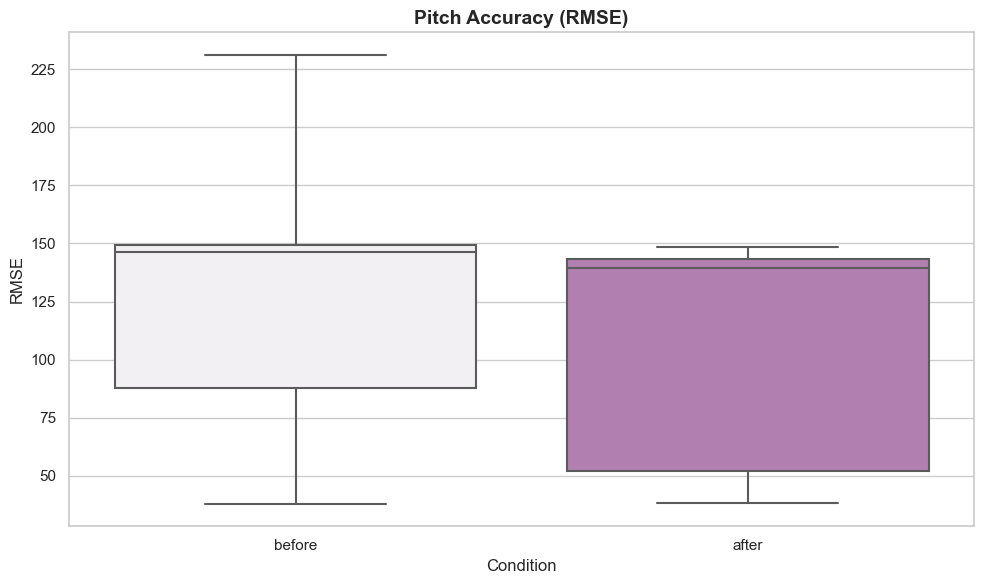

/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1474149887.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1474149887.py:31: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


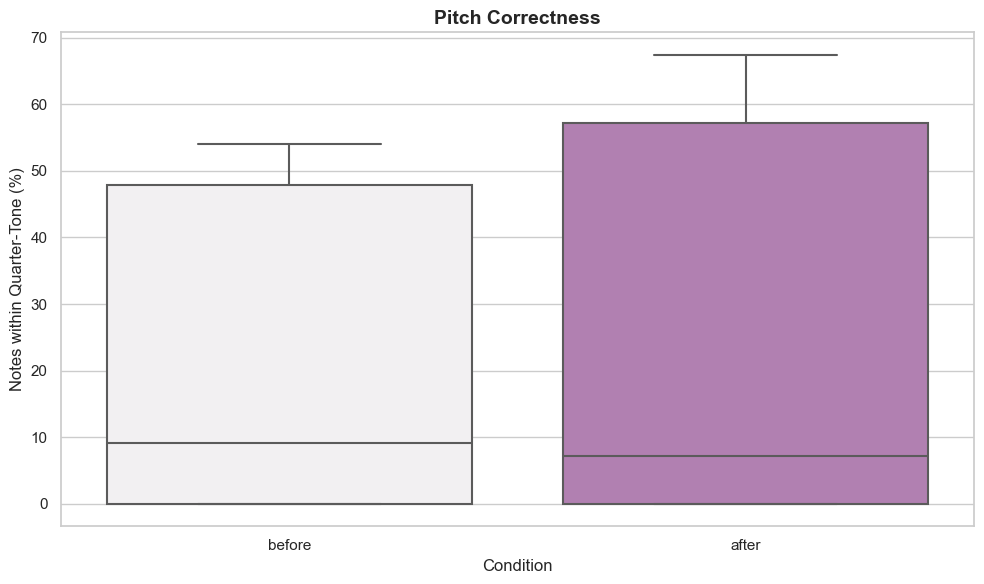

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom pastel purple palette
pastel_purples = sns.light_palette("purple", n_colors=3)
sns.set_theme(style="whitegrid")

# Order for the x-axis
condition_order = ['before', 'after']

# --- Plot 1: Pitch Accuracy (RMSE) with Presentation Styling ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metrics, 
    x='condition', 
    y='rmse', 
    order=condition_order, 
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)
plt.title('Pitch Accuracy (RMSE)', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tight_layout()
plt.savefig("pitch_rmse_transparent.png", transparent=True, bbox_inches='tight')
plt.show()

# --- Plot 2: Pitch Correctness with Presentation Styling ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metrics, 
    x='condition', 
    y='percent_notes_correct', 
    order=condition_order, 
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)
plt.title('Pitch Correctness', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Notes within Quarter-Tone (%)', fontsize=12)
plt.tight_layout()
plt.savefig("pitch_correctness_transparent.png", transparent=True, bbox_inches='tight')
plt.show()

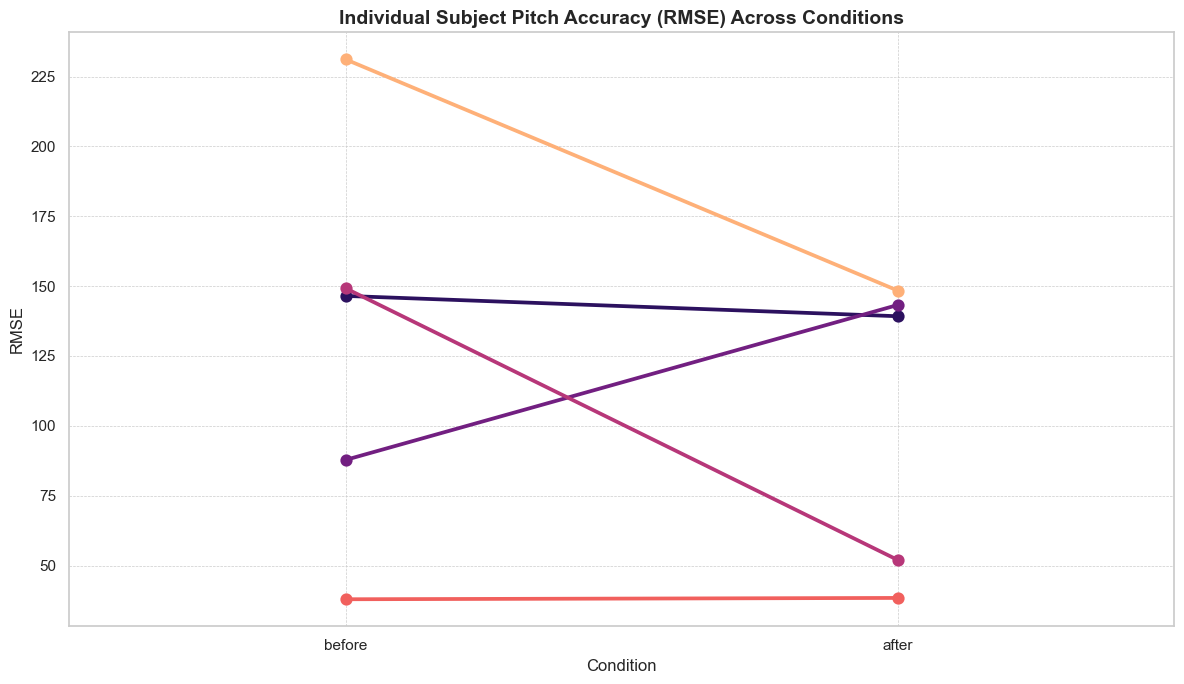

In [17]:
plt.figure(figsize=(12, 7))

# Create a custom pastel purple palette for the subjects
# The number of colors should match the number of unique subjects
n_subjects = df_metrics['subjectId'].nunique()
pastel_purples_subjects = sns.color_palette("magma", n_colors=n_subjects)

# Create the point plot using the full df_metrics DataFrame
ax = sns.pointplot(
    data=df_metrics,
    x='condition',
    y='rmse',
    hue='subjectId',
    order=['before', 'after'], # Include 'none' in the order
    palette=pastel_purples_subjects
)

# Improve readability
ax.get_legend().remove() # Keep legend removed for clarity with multiple lines
plt.title('Individual Subject Pitch Accuracy (RMSE) Across Conditions', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Tidy layout
plt.tight_layout()

# Save the figure with a transparent background
plt.savefig("individual_pitch_rmse_transparent.png", transparent=True, bbox_inches='tight')

plt.show()

/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1976726530.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1976726530.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/1976726530.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


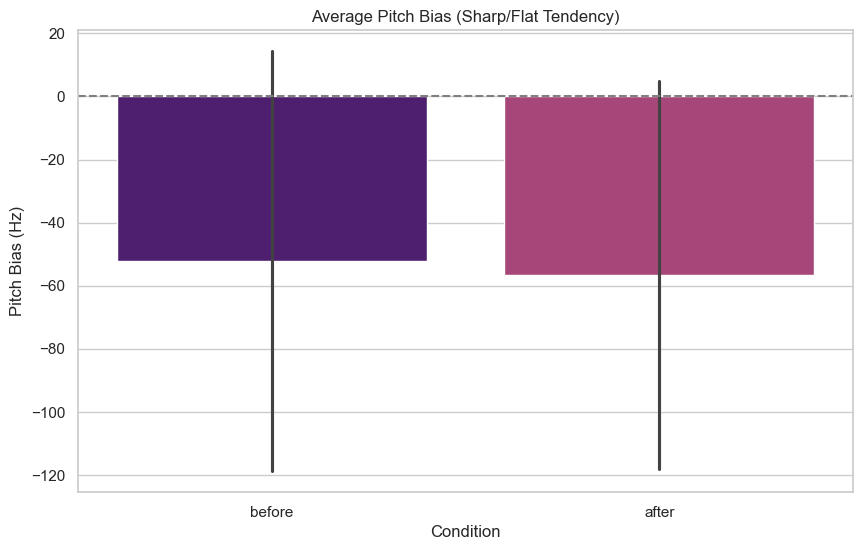

In [18]:
plt.figure(figsize=(10, 6))
purple_palette = sns.color_palette("magma", n_colors=3)


sns.barplot(
    data=df_metrics,
    x='condition',
    y='pitch_bias_hz',
    order=condition_order,
    palette=purple_palette,
    ci='sd' # Show standard deviation as error bars
)

plt.axhline(0, color='grey', linestyle='--')
plt.title('Average Pitch Bias (Sharp/Flat Tendency)')
plt.xlabel('Condition')
plt.ylabel('Pitch Bias (Hz)')
plt.show()

/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3596883516.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3596883516.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


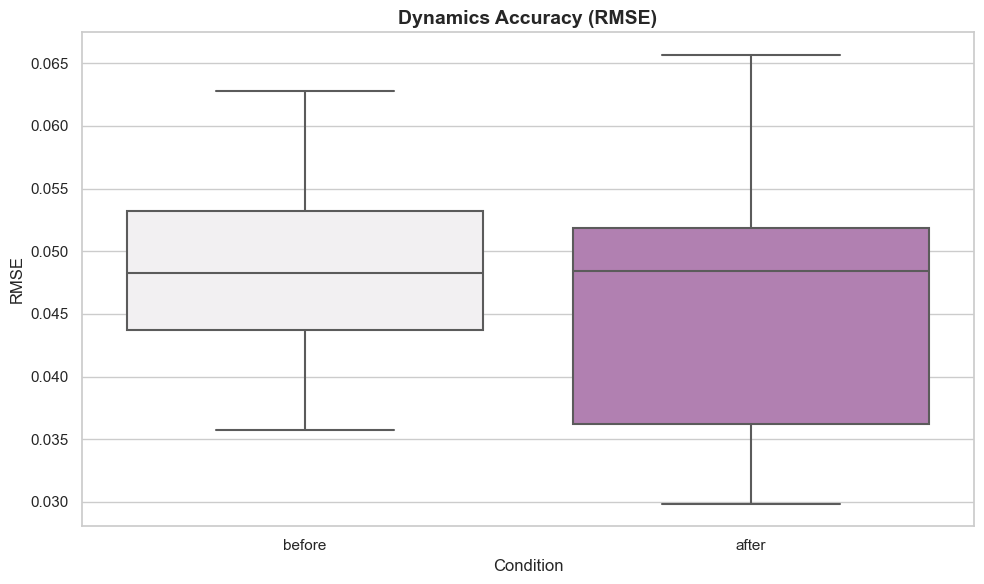

/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3596883516.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3596883516.py:28: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


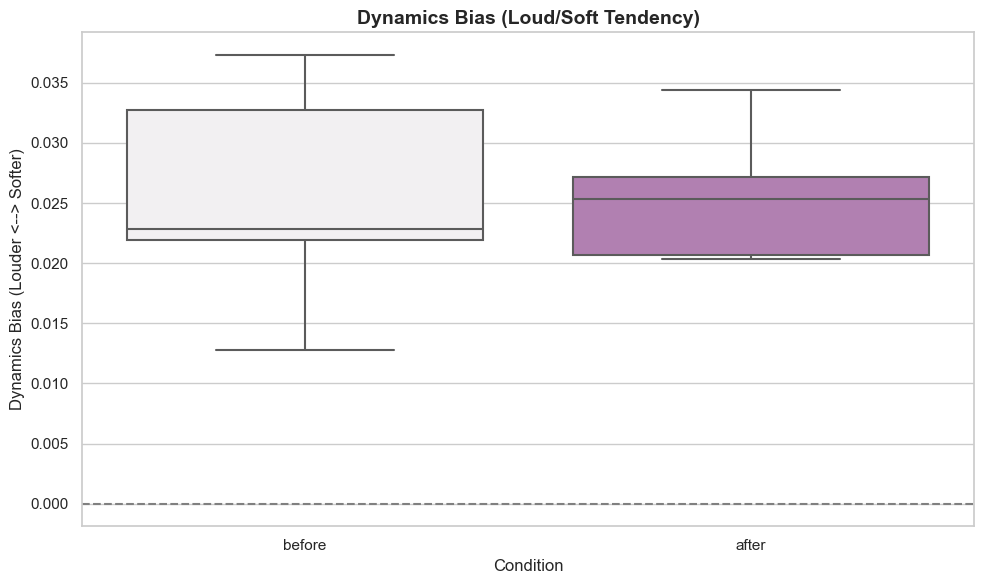

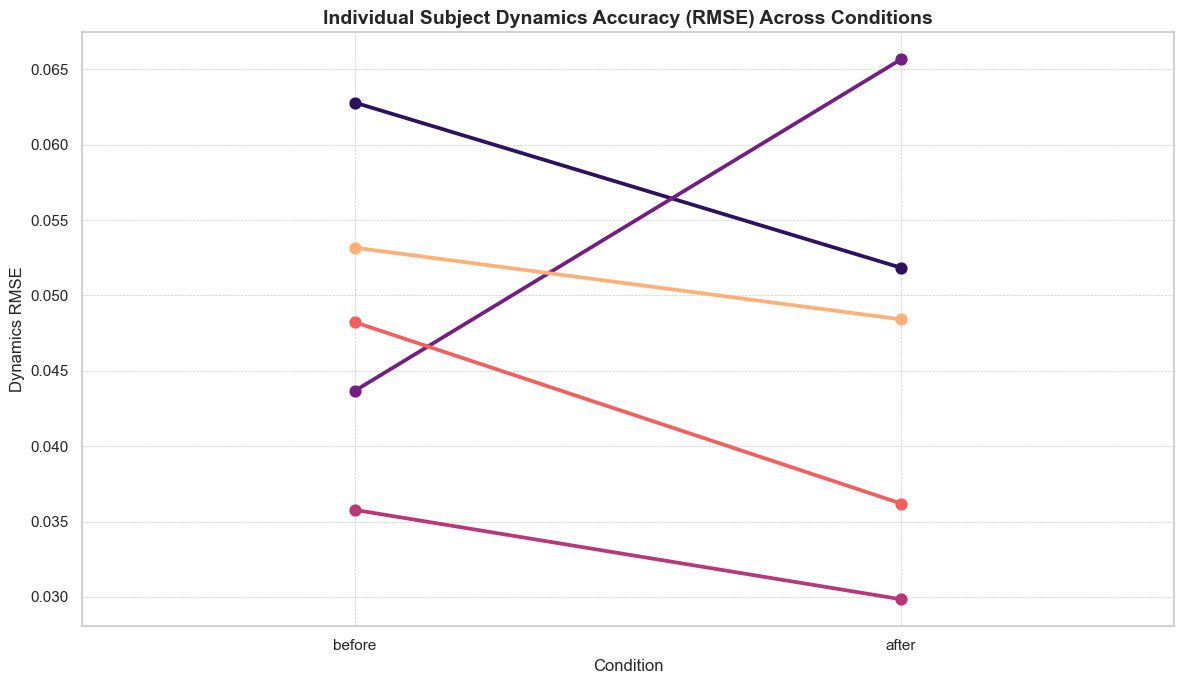

In [19]:

# --- Create visualizations for DYNAMICS performance ---

# Create a custom pastel purple palette
pastel_purples = sns.light_palette("purple", n_colors=3)
sns.set_theme(style="whitegrid")
condition_order = ['before', 'after']

# --- Plot 1: Dynamics Accuracy (RMSE) with Presentation Styling ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metrics, 
    x='condition', 
    y='dynamics_rmse', 
    order=condition_order, 
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)
plt.title('Dynamics Accuracy (RMSE)', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tight_layout()
plt.savefig("dynamics_rmse_transparent.png", transparent=True, bbox_inches='tight')
plt.show()

# --- Plot 2: Dynamics Bias with Presentation Styling ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metrics, 
    x='condition', 
    y='dynamics_bias', 
    order=condition_order, 
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)
plt.title('Dynamics Bias (Loud/Soft Tendency)', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Dynamics Bias (Louder <--> Softer)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig("dynamics_bias_transparent.png", transparent=True, bbox_inches='tight')
plt.show()

# --- 3. Point Plot for Individual Dynamics Improvement ---
plt.figure(figsize=(12, 7))
n_subjects = df_metrics['subjectId'].nunique()
# Using the "Purples" sequential colormap for better visibility
purple_palette_subjects = sns.color_palette("magma", n_colors=n_subjects)

# Create the point plot for dynamics
ax = sns.pointplot(
    data=df_metrics,
    x='condition',
    y='dynamics_rmse',
    hue='subjectId',
    order=['before', 'after'],
    palette=purple_palette_subjects
)

# Improve readability
ax.get_legend().remove()
plt.title('Individual Subject Dynamics Accuracy (RMSE) Across Conditions', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Dynamics RMSE', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("individual_dynamics_rmse_transparent.png", transparent=True, bbox_inches='tight')
plt.show()


/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3794792692.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3794792692.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


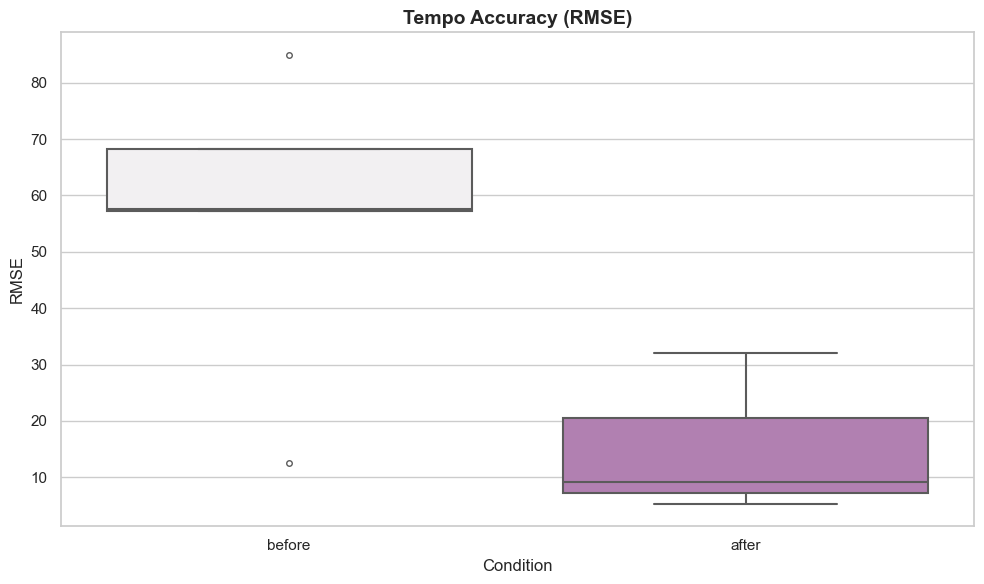

/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3794792692.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_0/43hbbhf92ms0v84d8mnpnnjr0000gn/T/ipykernel_53089/3794792692.py:28: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(


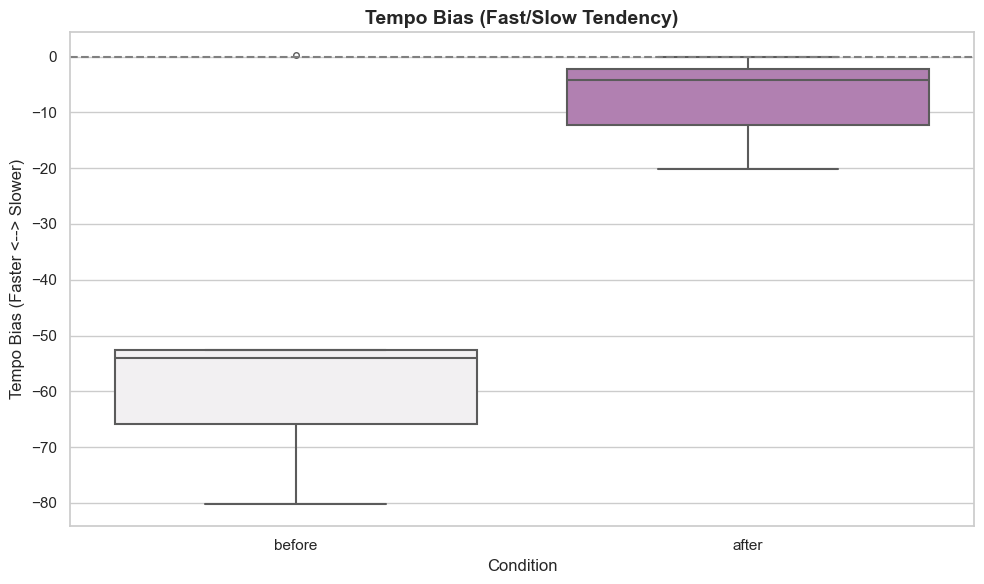

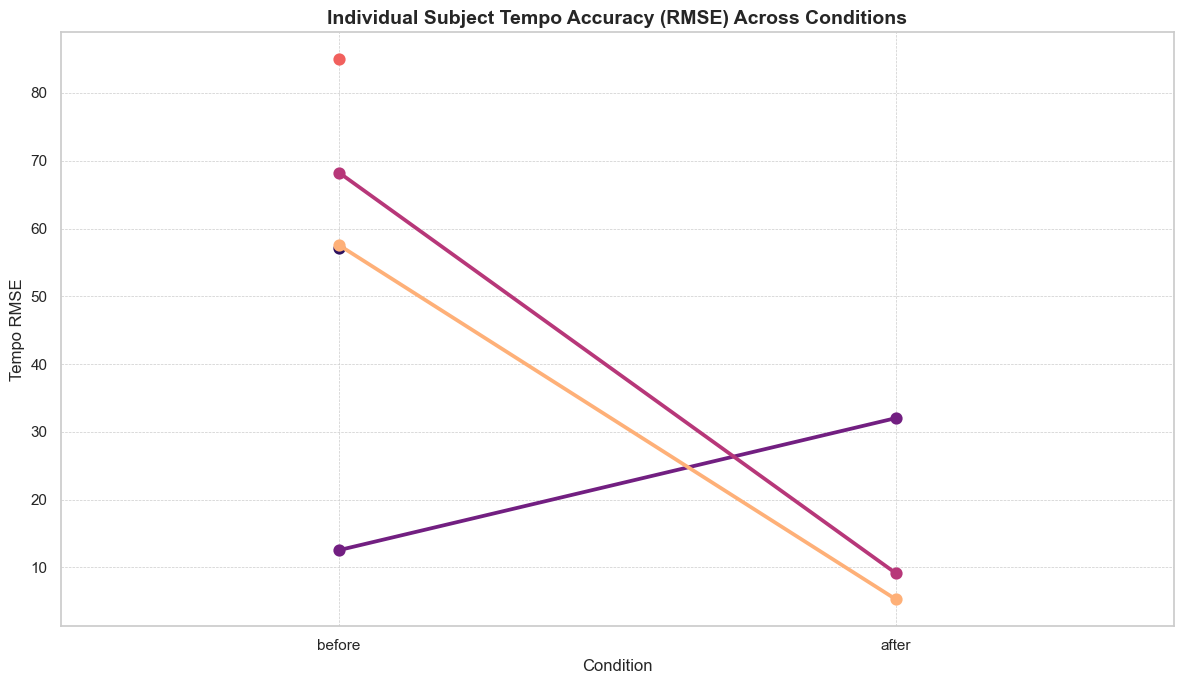

In [20]:

# --- Create visualizations for TEMPO performance ---

# Set a purple color theme and style
pastel_purples = sns.light_palette("purple", n_colors=3)
sns.set_theme(style="whitegrid")
condition_order = ['before', 'after']

# --- Plot 1: Tempo Accuracy (RMSE) with Presentation Styling ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metrics, 
    x='condition', 
    y='tempo_rmse', 
    order=condition_order, 
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)
plt.title('Tempo Accuracy (RMSE)', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tight_layout()
plt.savefig("tempo_rmse_transparent.png", transparent=True, bbox_inches='tight')
plt.show()

# --- Plot 2: Tempo Bias with Presentation Styling ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_metrics, 
    x='condition', 
    y='tempo_bias', 
    order=condition_order, 
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)
plt.title('Tempo Bias (Fast/Slow Tendency)', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Tempo Bias (Faster <--> Slower)', fontsize=12)
plt.axhline(0, color='grey', linestyle='--')
plt.tight_layout()
plt.savefig("tempo_bias_transparent.png", transparent=True, bbox_inches='tight')
plt.show()

# --- 3. Point Plot for Individual Tempo Improvement ---
plt.figure(figsize=(12, 7))
n_subjects = df_metrics['subjectId'].nunique()
# Using the "Purples" sequential colormap for better visibility
purple_palette_subjects = sns.color_palette("magma", n_colors=n_subjects)

# Create the point plot for tempo
ax = sns.pointplot(
    data=df_metrics,
    x='condition',
    y='tempo_rmse',
    hue='subjectId',
    order=['before', 'after'],
    palette=purple_palette_subjects
)

# Improve readability
ax.get_legend().remove()
plt.title('Individual Subject Tempo Accuracy (RMSE) Across Conditions', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Tempo RMSE', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("individual_tempo_rmse_transparent.png", transparent=True, bbox_inches='tight')
plt.show()


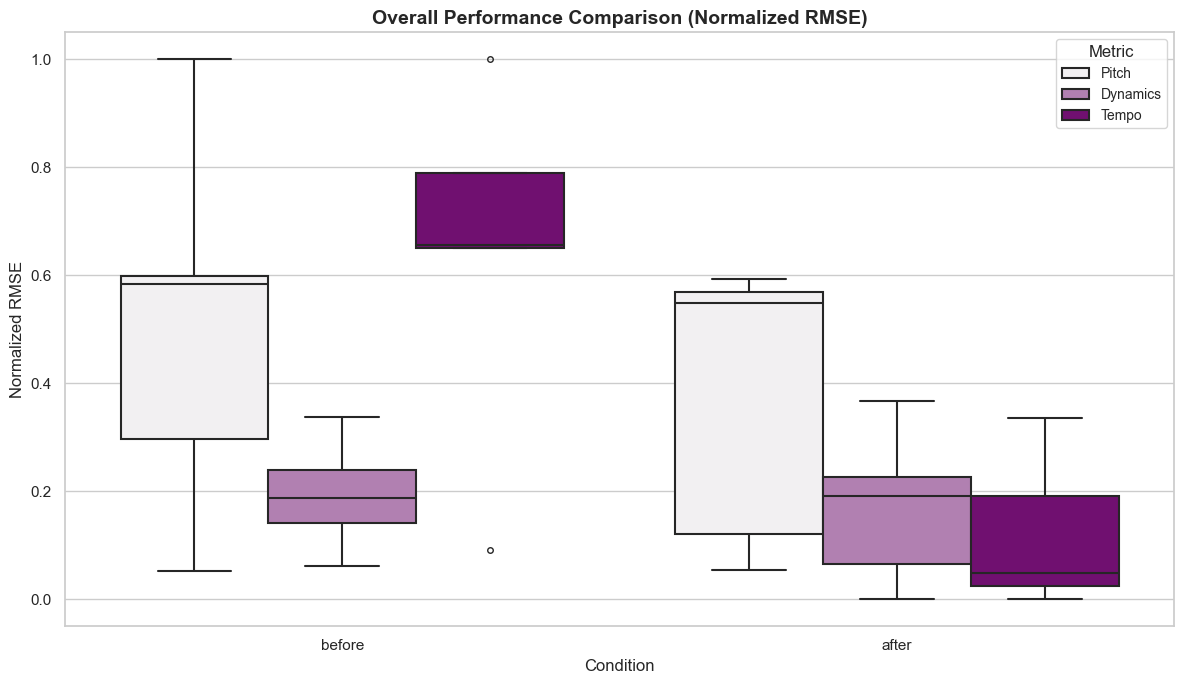

In [21]:
# --- Create a combined visualization for ALL NORMALIZED RMSE scores ---

# 1. Reshape the DataFrame from wide to long format
df_long = pd.melt(
    df_metrics, 
    id_vars=['subjectId', 'condition'], 
    value_vars=['rmse', 'dynamics_rmse', 'tempo_rmse'],
    var_name='metric_type', 
    value_name='RMSE'
)

# 2. Make the metric names more readable
df_long['metric_type'] = df_long['metric_type'].replace({
    'rmse': 'Pitch',
    'dynamics_rmse': 'Dynamics',
    'tempo_rmse': 'Tempo'
})

# 3. Normalize the RMSE values for each metric type independently (Min-Max Scaling)
df_long['Normalized RMSE'] = df_long.groupby('metric_type')['RMSE'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# 4. Create the plot with custom styling for presentation
# Create a custom pastel purple palette
pastel_purples = sns.light_palette("purple", n_colors=3)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7)) # Adjusted size for presentation slides

ax = sns.boxplot(
    data=df_long,
    x='condition',
    y='Normalized RMSE', # Use the new normalized column
    hue='metric_type',
    order=condition_order,
    palette=pastel_purples,
    linewidth=1.5,
    fliersize=4
)

# 5. Improve readability and add titles
plt.title('Overall Performance Comparison (Normalized RMSE)', fontsize=14, weight='bold')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Normalized RMSE', fontsize=12)
plt.legend(title="Metric", title_fontsize='12', fontsize='10', loc='upper right')

# Tidy layout
plt.tight_layout()

# Save the figure with a transparent background before showing it
plt.savefig("combined_rmse_transparent.png", transparent=True, bbox_inches='tight')

plt.show()